# Training and evaluation notebook
Round 3 no. 5, binary, based on only class 0 (actively eroding) and class 4 (restored) from the original dataset, and trained on only bands

In [1]:
## imports
import glob
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, accuracy_score

## 1. Construct dataset

In [2]:
# Simply reading the formerly created pickle file, changing it's name to 'merged_df'
# To confirm, you can load and view the combined dataset
with open("combined_dataset.pkl", 'rb') as file:
    merged_df = pd.read_pickle(file)

merged_df

,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,sample_location_id,class
0,0.00495,0.01885,0.03610,0.05020,0.09065,0.13930,0.15855,0.18270,0.19205,0.19175,0.20290,0.1097,201701,2
1,0.01040,0.02405,0.03980,0.05720,0.10385,0.16755,0.19370,0.21600,0.23420,0.24700,0.22290,0.1204,201701,2
2,0.01510,0.02905,0.06635,0.04515,0.12920,0.38280,0.47410,0.49955,0.50775,0.50890,0.24765,0.1219,201701,2
3,0.01345,0.02925,0.06315,0.04920,0.12335,0.28515,0.33710,0.39055,0.37655,0.42050,0.23555,0.1175,201701,2
4,0.01575,0.02970,0.06900,0.04870,0.13360,0.39940,0.49485,0.52430,0.53900,0.48935,0.23950,0.1177,201701,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1152806,0.03720,0.04660,0.06660,0.08560,0.13300,0.21200,0.24360,0.26880,0.28690,0.27960,0.28600,0.1640,202312,2
1152807,0.03840,0.04250,0.07690,0.08000,0.14000,0.25190,0.28530,0.34760,0.33920,0.32180,0.29830,0.1563,202312,2
1152808,0.04280,0.04960,0.06970,0.08880,0.12820,0.18960,0.21990,0.25540,0.25480,0.25390,0.27920,0.1567,202312,2
1152809,0.03170,0.04110,0.06480,0.07660,0.13350,0.23340,0.27290,0.30900,0.30940,0.29640,0.30290,0.1617,202312,2


In [3]:
# renaming 'class' column to 'classes' to fix python error
merged_df = merged_df.rename(columns={'class': 'classes'})

In the following, I will make some new dataframes for binary classification:

In [4]:
# Step 2: Create a DataFrame with classes 0 and 4
class_0_4_df = merged_df[merged_df['classes'].isin([0, 4])]

Dropping column:

In [5]:
class_0_4_df = class_0_4_df.drop('sample_location_id', axis=1)

## Constructing train and test sets

Starting by shuffling:

In [6]:
# Shuffle the DataFrame using a random seed, for example, seed=42
class_0_4_df = class_0_4_df.sample(frac=1, random_state=42).reset_index(drop=True)
class_0_4_df

,B1,B2,B3,B4,B5,B6,B7,B8,B8A,B9,B11,B12,classes
0,0.0375,0.0494,0.0757,0.09110,0.1479,0.25310,0.2877,0.3186,0.32770,0.34120,0.26070,0.15460,0
1,0.0331,0.0494,0.0660,0.07730,0.1264,0.19050,0.2172,0.2216,0.25130,0.25590,0.26710,0.16080,4
2,0.0359,0.0363,0.0562,0.07020,0.1192,0.17550,0.2041,0.2354,0.24480,0.25390,0.25000,0.13720,0
3,0.0349,0.0396,0.0586,0.05320,0.1206,0.19860,0.2210,0.2688,0.26170,0.25590,0.20070,0.09990,4
4,0.0280,0.0300,0.0452,0.04300,0.1000,0.21440,0.2472,0.2592,0.28510,0.30550,0.18570,0.10140,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
382845,0.0391,0.0590,0.0809,0.10320,0.1477,0.20250,0.2354,0.2658,0.27580,0.25200,0.28220,0.16230,0
382846,0.0371,0.0409,0.0650,0.07705,0.1209,0.19895,0.2286,0.2916,0.27385,0.21225,0.26965,0.15675,4
382847,0.0351,0.0492,0.0719,0.06300,0.1211,0.24350,0.2838,0.3408,0.33520,0.34560,0.24510,0.12500,0
382848,0.0367,0.0425,0.0677,0.06330,0.1339,0.26580,0.3016,0.3428,0.34650,0.35190,0.23070,0.11660,0


Now making splits:

In [7]:
from sklearn.model_selection import train_test_split

# Assuming your features are all columns except 'classes', and 'classes' is the target variable
X = class_0_4_df.drop('classes', axis=1)  # Features
y = class_0_4_df['classes']  # Target variable

# Perform the split with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# X_train and y_train will now contain 70% of the data, X_test and y_test will contain 30%
# Both splits will have the same proportion of class 0 and 4 as the original dataset

## Hyperparameter optimisation

In [18]:
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

def objective(trial):
    # Hyperparameters to tune
    n_estimators = trial.suggest_int('n_estimators', 50, 400)
    max_depth = trial.suggest_int('max_depth', 2, 32, log=True)
    # Ensuring min_samples_split is an int >= 2
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    # Ensuring min_samples_leaf is a float within (0.0, 0.5], you could also use suggest_int if you want specific integer values
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)

    # Initialize the classifier with the current hyperparameters
    clf = RandomForestClassifier(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )

    # Train the classifier
    clf.fit(X_train, y_train)

    # Predict on the validation set
    predictions = clf.predict(X_test)

    # Compute and return the accuracy
    accuracy = accuracy_score(y_test, predictions)
    return accuracy


In [19]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)  # Adjust the number of trials as needed

print(f"Best trial: {study.best_trial.params}")

[I 2024-02-12 14:12:23,401] A new study created in memory with name: no-name-b1867f78-28b1-41b7-819b-c3ff4b434f54
[I 2024-02-12 14:14:18,054] Trial 0 finished with value: 0.8880501501893692 and parameters: {'n_estimators': 188, 'max_depth': 14, 'min_samples_split': 5, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8880501501893692.
[I 2024-02-12 14:14:38,363] Trial 1 finished with value: 0.6539898132427844 and parameters: {'n_estimators': 214, 'max_depth': 2, 'min_samples_split': 9, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.8880501501893692.
[I 2024-02-12 14:15:17,992] Trial 2 finished with value: 0.6822602411736537 and parameters: {'n_estimators': 240, 'max_depth': 4, 'min_samples_split': 7, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.8880501501893692.
[I 2024-02-12 14:15:38,812] Trial 3 finished with value: 0.6797962648556876 and parameters: {'n_estimators': 126, 'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 0 with value: 0

Best trial: {'n_estimators': 396, 'max_depth': 24, 'min_samples_split': 9, 'min_samples_leaf': 3}


### Training/evaluating

First a logistic regression model:

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, f1_score, cohen_kappa_score, accuracy_score
from sklearn.preprocessing import StandardScaler

# Initialize the Logistic Regression classifier
log_reg = LogisticRegression(max_iter=1000) # Increase max_iter if convergence warnings occur

# Train the classifier on the training set
log_reg.fit(X_train, y_train)

# Predict on the test set
log_reg_predictions = log_reg.predict(X_test)

# Predict on the test set
lr_predictions = log_reg.predict(X_test)

# Calculate metrics, specifying pos_label for binary classification
lr_precision = precision_score(y_test, lr_predictions, average='weighted')
log_reg_accuracy = accuracy_score(y_test, log_reg_predictions)
lr_recall = recall_score(y_test, lr_predictions, average='weighted')
lr_f1 = f1_score(y_test, lr_predictions, average='weighted')
lr_kappa = cohen_kappa_score(y_test, lr_predictions)

# Print metrics
print("Logistic Regression Performance:")
print(f"Precision: {lr_precision}")
print(f'Logistic Regression Accuracy: {log_reg_accuracy}')
print(f"Recall: {lr_recall}")
print(f"F1 Score: {lr_f1}")
print(f"Cohen's Kappa: {lr_kappa}")

Logistic Regression Performance:
Precision: 0.6923499676109348
Logistic Regression Accuracy: 0.7011013887075007
Recall: 0.7011013887075007
F1 Score: 0.6617430942161431
Cohen's Kappa: 0.2416782796358462


Now an RF model:

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Best trial: {'n_estimators': 396, 'max_depth': 24, 'min_samples_split': 9, 'min_samples_leaf': 3}

# Assuming you have your optimized hyperparameters, for example:
optimized_hyperparameters = {
    'n_estimators': 396,
    'max_depth': 24,
    'min_samples_split': 9,
    'min_samples_leaf': 3, 
    # Include other hyperparameters as necessary
}

# Initialize the RandomForestClassifier with optimized hyperparameters
clf = RandomForestClassifier(
    n_estimators=optimized_hyperparameters['n_estimators'],
    max_depth=optimized_hyperparameters['max_depth'],
    min_samples_split=optimized_hyperparameters['min_samples_split'],
    min_samples_leaf=optimized_hyperparameters['min_samples_leaf'],
    random_state=42  # Ensuring reproducibility
)

# Train the classifier on the training set
clf.fit(X_train, y_train)

# Predict on the test set
predictions = clf.predict(X_test)

# Compute and display the accuracy
accuracy = accuracy_score(y_test, predictions)
rf_precision = precision_score(y_test, predictions, average='weighted')
rf_recall = recall_score(y_test, predictions, average='weighted')
rf_f1 = f1_score(y_test, predictions, average='weighted')
rf_kappa = cohen_kappa_score(y_test, predictions)

# Print metrics
print("RandomForest Performance:")
print(f"Precision: {rf_precision}")
print(f"Recall: {rf_recall}")
print(f"F1 Score: {rf_f1}")
print(f"Cohen's Kappa: {rf_kappa}")
print(f'Optimized RandomForest Accuracy: {accuracy}')

RandomForest Performance:
Precision: 0.9568993786558202
Recall: 0.9568760611205432
F1 Score: 0.9566457150827141
Cohen's Kappa: 0.9040414306067597
Optimized RandomForest Accuracy: 0.9568760611205432


## Confusion matrix

- You'll also want to output an aggregated prediction confusion matrix (from the cross-validation), preferably as a seaborn (sns) figure. 

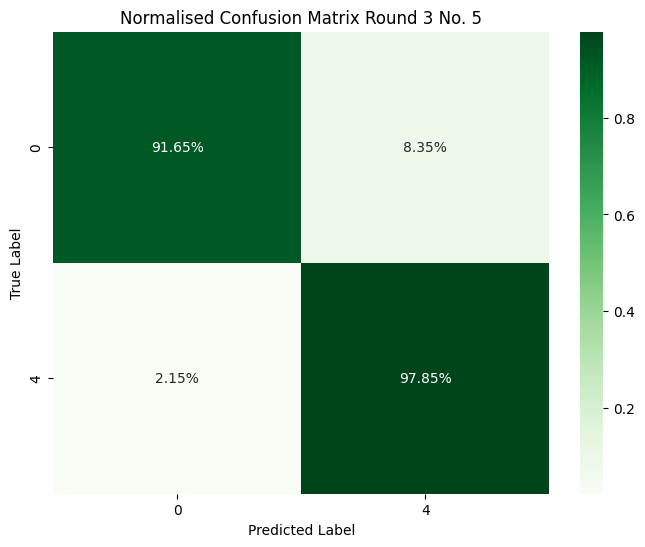

In [28]:
from sklearn.metrics import confusion_matrix, cohen_kappa_score
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming predictions, y_test are already defined

# Compute the normalized confusion matrix
cm_normalized = confusion_matrix(y_test, predictions, labels=[0, 4], normalize='true')

# Visualize the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2%", cmap="Greens", xticklabels=[0, 4], yticklabels=[0, 4])
plt.title('Normalised Confusion Matrix Round 3 No. 5')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Feature permutation importance

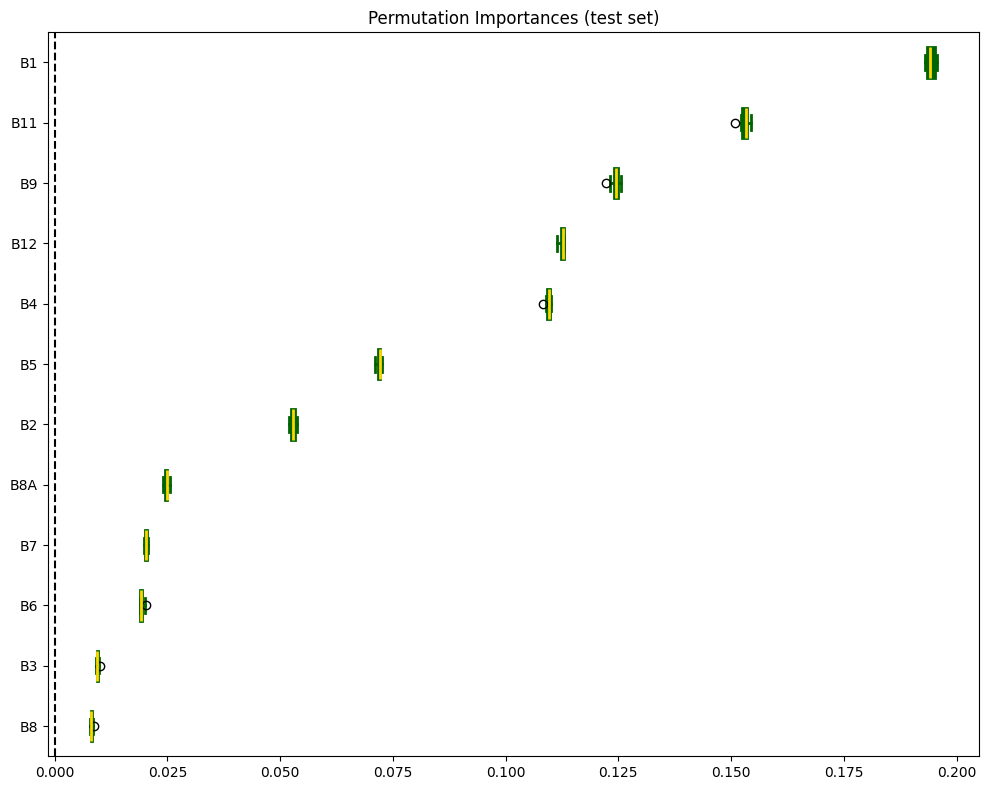

In [32]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np

# Assuming clf is your trained RandomForestClassifier model
# and X_test, y_test are your test datasets

result = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Sorting features by importance
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(10, 8))
bp = ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx],
                patch_artist=True,  # To fill with color
                )

# Customizing the boxplot color to dark green
for box in bp['boxes']:
    # Change box color
    box.set(color='darkgreen', linewidth=2)  # Box edge color
    box.set(facecolor='darkgreen')  # Box fill color

# Optionally, customize whiskers, fliers, caps, and medians if needed
for whisker in bp['whiskers']:
    whisker.set(color='darkgreen', linewidth=2)
for cap in bp['caps']:
    cap.set(color='darkgreen', linewidth=2)
for median in bp['medians']:
    median.set(color='gold', linewidth=2)  # Making the median stand out

ax.axvline(x=0, color="k", linestyle="--")
ax.set_title("Permutation Importances (test set)")
plt.tight_layout()
plt.show()